# [OpenCV-Python Tutorial] Classification

In this notebook, we will learn how to perform Object Classification using Visual Bag of Words(VBoW), spatial histogram feature, and SVM classifier.

---

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os, sys
import tarfile
import time
import random
#import cPickle as pickle <- Python2
import pickle

In [6]:
caltech_url = 'http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz'
caltech_filename = '101_ObjectCategories.tar.gz'
caltech_dir = '101_ObjectCategories/'

numTrain = 15
numTest = 15
numClasses = 102
numWords = 600

vocabPath = os.path.join(caltech_dir, 'vocab.pkl')
svmPath = os.path.join(caltech_dir, 'svm_data.dat')

# Dataset

## 1. Download Caltech-101 dataset

In [9]:
def download_file(url, path):
    #import urllib2
    from urllib.request import urlopen
    file_name = url.split('/')[-1]
    #u = urllib2.urlopen(url)
    u = urlopen(url)
    f = open(os.path.join(path, file_name), 'wb')
    meta = u.info()
    file_size = int(meta.get_all("Content-Length")[0])
    print("Downloading: %s Bytes: %s" % (file_name, file_size))

    download_size = 0
    block_size = 8192
    while True:
        buf = u.read(block_size)
        if not buf:
            break
        download_size += len(buf)
        f.write(buf)
        status = "\r%12d  [%3.2f%%]" % (download_size, download_size * 100. / file_size)
        print(status, sys.stdout.flush())
    f.close()

if not os.path.exists(caltech_dir) or not os.path.exists(os.path.join(caltech_dir, 'airplanes')):
    print('Downloading Caltech-101')
    if not os.path.exists(caltech_filename) or os.path.getsize(caltech_filename) != 131740031:
        download_file(caltech_url, '.')
    print('Extracting Caltech-101')
    with tarfile.open(caltech_filename) as tar:
        tar.extractall()

print('Caltech-101 dataset checked')

Downloading: 101_ObjectCategories.tar.gz Bytes: 131740031
        8192  [0.01%] None
       16384  [0.01%] None
       24576  [0.02%] None
       32768  [0.02%] None
       40960  [0.03%] None
       49152  [0.04%] None
       57344  [0.04%] None
       65536  [0.05%] None
       73728  [0.06%] None
       81920  [0.06%] None
       90112  [0.07%] None
       98304  [0.07%] None
      106496  [0.08%] None
      114688  [0.09%] None
      122880  [0.09%] None
      131072  [0.10%] None
      139264  [0.11%] None
      147456  [0.11%] None
      155648  [0.12%] None
      163840  [0.12%] None
      172032  [0.13%] None
      180224  [0.14%] None
      188416  [0.14%] None
      196608  [0.15%] None
      204800  [0.16%] None
      212992  [0.16%] None
      221184  [0.17%] None
      229376  [0.17%] None
      237568  [0.18%] None
      245760  [0.19%] None
      253952  [0.19%] None
      262144  [0.20%] None
      270336  [0.21%] None
      278528  [0.21%] None
      286720  [0.22%] No

     2473984  [1.88%] None
     2482176  [1.88%] None
     2490368  [1.89%] None
     2498560  [1.90%] None
     2506752  [1.90%] None
     2514944  [1.91%] None
     2523136  [1.92%] None
     2531328  [1.92%] None
     2539520  [1.93%] None
     2547712  [1.93%] None
     2555904  [1.94%] None
     2564096  [1.95%] None
     2572288  [1.95%] None
     2580480  [1.96%] None
     2588672  [1.96%] None
     2596864  [1.97%] None
     2605056  [1.98%] None
     2613248  [1.98%] None
     2621440  [1.99%] None
     2629632  [2.00%] None
     2637824  [2.00%] None
     2646016  [2.01%] None
     2654208  [2.01%] None
     2662400  [2.02%] None
     2670592  [2.03%] None
     2678784  [2.03%] None
     2686976  [2.04%] None
     2695168  [2.05%] None
     2703360  [2.05%] None
     2711552  [2.06%] None
     2719744  [2.06%] None
     2727936  [2.07%] None
     2736128  [2.08%] None
     2744320  [2.08%] None
     2752512  [2.09%] None
     2760704  [2.10%] None
     2768896  [2.10%] None
 

     4964352  [3.77%] None
     4972544  [3.77%] None
     4980736  [3.78%] None
     4988928  [3.79%] None
     4997120  [3.79%] None
     5005312  [3.80%] None
     5013504  [3.81%] None
     5021696  [3.81%] None
     5029888  [3.82%] None
     5038080  [3.82%] None
     5046272  [3.83%] None
     5054464  [3.84%] None
     5062656  [3.84%] None
     5070848  [3.85%] None
     5079040  [3.86%] None
     5087232  [3.86%] None
     5095424  [3.87%] None
     5103616  [3.87%] None
     5111808  [3.88%] None
     5120000  [3.89%] None
     5128192  [3.89%] None
     5136384  [3.90%] None
     5144576  [3.91%] None
     5152768  [3.91%] None
     5160960  [3.92%] None
     5169152  [3.92%] None
     5177344  [3.93%] None
     5185536  [3.94%] None
     5193728  [3.94%] None
     5201920  [3.95%] None
     5210112  [3.95%] None
     5218304  [3.96%] None
     5226496  [3.97%] None
     5234688  [3.97%] None
     5242880  [3.98%] None
     5251072  [3.99%] None
     5259264  [3.99%] None
 

     7454720  [5.66%] None
     7462912  [5.66%] None
     7471104  [5.67%] None
     7479296  [5.68%] None
     7487488  [5.68%] None
     7495680  [5.69%] None
     7503872  [5.70%] None
     7512064  [5.70%] None
     7520256  [5.71%] None
     7528448  [5.71%] None
     7536640  [5.72%] None
     7544832  [5.73%] None
     7553024  [5.73%] None
     7561216  [5.74%] None
     7569408  [5.75%] None
     7577600  [5.75%] None
     7585792  [5.76%] None
     7593984  [5.76%] None
     7602176  [5.77%] None
     7610368  [5.78%] None
     7618560  [5.78%] None
     7626752  [5.79%] None
     7634944  [5.80%] None
     7643136  [5.80%] None
     7651328  [5.81%] None
     7659520  [5.81%] None
     7667712  [5.82%] None
     7675904  [5.83%] None
     7684096  [5.83%] None
     7692288  [5.84%] None
     7700480  [5.85%] None
     7708672  [5.85%] None
     7716864  [5.86%] None
     7725056  [5.86%] None
     7733248  [5.87%] None
     7741440  [5.88%] None
     7749632  [5.88%] None
 

     9945088  [7.55%] None
     9953280  [7.56%] None
     9961472  [7.56%] None
     9969664  [7.57%] None
     9977856  [7.57%] None
     9986048  [7.58%] None
     9994240  [7.59%] None
    10002432  [7.59%] None
    10010624  [7.60%] None
    10018816  [7.60%] None
    10027008  [7.61%] None
    10035200  [7.62%] None
    10043392  [7.62%] None
    10051584  [7.63%] None
    10059776  [7.64%] None
    10067968  [7.64%] None
    10076160  [7.65%] None
    10084352  [7.65%] None
    10092544  [7.66%] None
    10100736  [7.67%] None
    10108928  [7.67%] None
    10117120  [7.68%] None
    10125312  [7.69%] None
    10133504  [7.69%] None
    10141696  [7.70%] None
    10149888  [7.70%] None
    10158080  [7.71%] None
    10166272  [7.72%] None
    10174464  [7.72%] None
    10182656  [7.73%] None
    10190848  [7.74%] None
    10199040  [7.74%] None
    10207232  [7.75%] None
    10215424  [7.75%] None
    10223616  [7.76%] None
    10231808  [7.77%] None
    10240000  [7.77%] None
 

    12435456  [9.44%] None
    12443648  [9.45%] None
    12451840  [9.45%] None
    12460032  [9.46%] None
    12468224  [9.46%] None
    12476416  [9.47%] None
    12484608  [9.48%] None
    12492800  [9.48%] None
    12500992  [9.49%] None
    12509184  [9.50%] None
    12517376  [9.50%] None
    12525568  [9.51%] None
    12533760  [9.51%] None
    12541952  [9.52%] None
    12550144  [9.53%] None
    12558336  [9.53%] None
    12566528  [9.54%] None
    12574720  [9.55%] None
    12582912  [9.55%] None
    12591104  [9.56%] None
    12599296  [9.56%] None
    12607488  [9.57%] None
    12615680  [9.58%] None
    12623872  [9.58%] None
    12632064  [9.59%] None
    12640256  [9.59%] None
    12648448  [9.60%] None
    12656640  [9.61%] None
    12664832  [9.61%] None
    12673024  [9.62%] None
    12681216  [9.63%] None
    12689408  [9.63%] None
    12697600  [9.64%] None
    12705792  [9.64%] None
    12713984  [9.65%] None
    12722176  [9.66%] None
    12730368  [9.66%] None
 

    14860288  [11.28%] None
    14868480  [11.29%] None
    14876672  [11.29%] None
    14884864  [11.30%] None
    14893056  [11.30%] None
    14901248  [11.31%] None
    14909440  [11.32%] None
    14917632  [11.32%] None
    14925824  [11.33%] None
    14934016  [11.34%] None
    14942208  [11.34%] None
    14950400  [11.35%] None
    14958592  [11.35%] None
    14966784  [11.36%] None
    14974976  [11.37%] None
    14983168  [11.37%] None
    14991360  [11.38%] None
    14999552  [11.39%] None
    15007744  [11.39%] None
    15015936  [11.40%] None
    15024128  [11.40%] None
    15032320  [11.41%] None
    15040512  [11.42%] None
    15048704  [11.42%] None
    15056896  [11.43%] None
    15065088  [11.44%] None
    15073280  [11.44%] None
    15081472  [11.45%] None
    15089664  [11.45%] None
    15097856  [11.46%] None
    15106048  [11.47%] None
    15114240  [11.47%] None
    15122432  [11.48%] None
    15130624  [11.49%] None
    15138816  [11.49%] None
    15147008  [11.50

    17260544  [13.10%] None
    17268736  [13.11%] None
    17276928  [13.11%] None
    17285120  [13.12%] None
    17293312  [13.13%] None
    17301504  [13.13%] None
    17309696  [13.14%] None
    17317888  [13.15%] None
    17326080  [13.15%] None
    17334272  [13.16%] None
    17342464  [13.16%] None
    17350656  [13.17%] None
    17358848  [13.18%] None
    17367040  [13.18%] None
    17375232  [13.19%] None
    17383424  [13.20%] None
    17391616  [13.20%] None
    17399808  [13.21%] None
    17408000  [13.21%] None
    17416192  [13.22%] None
    17424384  [13.23%] None
    17432576  [13.23%] None
    17440768  [13.24%] None
    17448960  [13.24%] None
    17457152  [13.25%] None
    17465344  [13.26%] None
    17473536  [13.26%] None
    17481728  [13.27%] None
    17489920  [13.28%] None
    17498112  [13.28%] None
    17506304  [13.29%] None
    17514496  [13.29%] None
    17522688  [13.30%] None
    17530880  [13.31%] None
    17539072  [13.31%] None
    17547264  [13.32

    19660800  [14.92%] None
    19668992  [14.93%] None
    19677184  [14.94%] None
    19685376  [14.94%] None
    19693568  [14.95%] None
    19701760  [14.96%] None
    19709952  [14.96%] None
    19718144  [14.97%] None
    19726336  [14.97%] None
    19734528  [14.98%] None
    19742720  [14.99%] None
    19750912  [14.99%] None
    19759104  [15.00%] None
    19767296  [15.00%] None
    19775488  [15.01%] None
    19783680  [15.02%] None
    19791872  [15.02%] None
    19800064  [15.03%] None
    19808256  [15.04%] None
    19816448  [15.04%] None
    19824640  [15.05%] None
    19832832  [15.05%] None
    19841024  [15.06%] None
    19849216  [15.07%] None
    19857408  [15.07%] None
    19865600  [15.08%] None
    19873792  [15.09%] None
    19881984  [15.09%] None
    19890176  [15.10%] None
    19898368  [15.10%] None
    19906560  [15.11%] None
    19914752  [15.12%] None
    19922944  [15.12%] None
    19931136  [15.13%] None
    19939328  [15.14%] None
    19947520  [15.14

    22061056  [16.75%] None
    22069248  [16.75%] None
    22077440  [16.76%] None
    22085632  [16.76%] None
    22093824  [16.77%] None
    22102016  [16.78%] None
    22110208  [16.78%] None
    22118400  [16.79%] None
    22126592  [16.80%] None
    22134784  [16.80%] None
    22142976  [16.81%] None
    22151168  [16.81%] None
    22159360  [16.82%] None
    22167552  [16.83%] None
    22175744  [16.83%] None
    22183936  [16.84%] None
    22192128  [16.85%] None
    22200320  [16.85%] None
    22208512  [16.86%] None
    22216704  [16.86%] None
    22224896  [16.87%] None
    22233088  [16.88%] None
    22241280  [16.88%] None
    22249472  [16.89%] None
    22257664  [16.90%] None
    22265856  [16.90%] None
    22274048  [16.91%] None
    22282240  [16.91%] None
    22290432  [16.92%] None
    22298624  [16.93%] None
    22306816  [16.93%] None
    22315008  [16.94%] None
    22323200  [16.94%] None
    22331392  [16.95%] None
    22339584  [16.96%] None
    22347776  [16.96

    24461312  [18.57%] None
    24469504  [18.57%] None
    24477696  [18.58%] None
    24485888  [18.59%] None
    24494080  [18.59%] None
    24502272  [18.60%] None
    24510464  [18.61%] None
    24518656  [18.61%] None
    24526848  [18.62%] None
    24535040  [18.62%] None
    24543232  [18.63%] None
    24551424  [18.64%] None
    24559616  [18.64%] None
    24567808  [18.65%] None
    24576000  [18.65%] None
    24584192  [18.66%] None
    24592384  [18.67%] None
    24600576  [18.67%] None
    24608768  [18.68%] None
    24616960  [18.69%] None
    24625152  [18.69%] None
    24633344  [18.70%] None
    24641536  [18.70%] None
    24649728  [18.71%] None
    24657920  [18.72%] None
    24666112  [18.72%] None
    24674304  [18.73%] None
    24682496  [18.74%] None
    24690688  [18.74%] None
    24698880  [18.75%] None
    24707072  [18.75%] None
    24715264  [18.76%] None
    24723456  [18.77%] None
    24731648  [18.77%] None
    24739840  [18.78%] None
    24748032  [18.79

    26861568  [20.39%] None
    26869760  [20.40%] None
    26877952  [20.40%] None
    26886144  [20.41%] None
    26894336  [20.41%] None
    26902528  [20.42%] None
    26910720  [20.43%] None
    26918912  [20.43%] None
    26927104  [20.44%] None
    26935296  [20.45%] None
    26943488  [20.45%] None
    26951680  [20.46%] None
    26959872  [20.46%] None
    26968064  [20.47%] None
    26976256  [20.48%] None
    26984448  [20.48%] None
    26992640  [20.49%] None
    27000832  [20.50%] None
    27009024  [20.50%] None
    27017216  [20.51%] None
    27025408  [20.51%] None
    27033600  [20.52%] None
    27041792  [20.53%] None
    27049984  [20.53%] None
    27058176  [20.54%] None
    27066368  [20.55%] None
    27074560  [20.55%] None
    27082752  [20.56%] None
    27090944  [20.56%] None
    27099136  [20.57%] None
    27107328  [20.58%] None
    27115520  [20.58%] None
    27123712  [20.59%] None
    27131904  [20.60%] None
    27140096  [20.60%] None
    27148288  [20.61

    29261824  [22.21%] None
    29270016  [22.22%] None
    29278208  [22.22%] None
    29286400  [22.23%] None
    29294592  [22.24%] None
    29302784  [22.24%] None
    29310976  [22.25%] None
    29319168  [22.26%] None
    29327360  [22.26%] None
    29335552  [22.27%] None
    29343744  [22.27%] None
    29351936  [22.28%] None
    29360128  [22.29%] None
    29368320  [22.29%] None
    29376512  [22.30%] None
    29384704  [22.31%] None
    29392896  [22.31%] None
    29401088  [22.32%] None
    29409280  [22.32%] None
    29417472  [22.33%] None
    29425664  [22.34%] None
    29433856  [22.34%] None
    29442048  [22.35%] None
    29450240  [22.35%] None
    29458432  [22.36%] None
    29466624  [22.37%] None
    29474816  [22.37%] None
    29483008  [22.38%] None
    29491200  [22.39%] None
    29499392  [22.39%] None
    29507584  [22.40%] None
    29515776  [22.40%] None
    29523968  [22.41%] None
    29532160  [22.42%] None
    29540352  [22.42%] None
    29548544  [22.43

    31662080  [24.03%] None
    31670272  [24.04%] None
    31678464  [24.05%] None
    31686656  [24.05%] None
    31694848  [24.06%] None
    31703040  [24.06%] None
    31711232  [24.07%] None
    31719424  [24.08%] None
    31727616  [24.08%] None
    31735808  [24.09%] None
    31744000  [24.10%] None
    31752192  [24.10%] None
    31760384  [24.11%] None
    31768576  [24.11%] None
    31776768  [24.12%] None
    31784960  [24.13%] None
    31793152  [24.13%] None
    31801344  [24.14%] None
    31809536  [24.15%] None
    31817728  [24.15%] None
    31825920  [24.16%] None
    31834112  [24.16%] None
    31842304  [24.17%] None
    31850496  [24.18%] None
    31858688  [24.18%] None
    31866880  [24.19%] None
    31875072  [24.20%] None
    31883264  [24.20%] None
    31891456  [24.21%] None
    31899648  [24.21%] None
    31907840  [24.22%] None
    31916032  [24.23%] None
    31924224  [24.23%] None
    31932416  [24.24%] None
    31940608  [24.25%] None
    31948800  [24.25

    34062336  [25.86%] None
    34070528  [25.86%] None
    34078720  [25.87%] None
    34086912  [25.87%] None
    34095104  [25.88%] None
    34103296  [25.89%] None
    34111488  [25.89%] None
    34119680  [25.90%] None
    34127872  [25.91%] None
    34136064  [25.91%] None
    34144256  [25.92%] None
    34152448  [25.92%] None
    34160640  [25.93%] None
    34168832  [25.94%] None
    34177024  [25.94%] None
    34185216  [25.95%] None
    34193408  [25.96%] None
    34201600  [25.96%] None
    34209792  [25.97%] None
    34217984  [25.97%] None
    34226176  [25.98%] None
    34234368  [25.99%] None
    34242560  [25.99%] None
    34250752  [26.00%] None
    34258944  [26.00%] None
    34267136  [26.01%] None
    34275328  [26.02%] None
    34283520  [26.02%] None
    34291712  [26.03%] None
    34299904  [26.04%] None
    34308096  [26.04%] None
    34316288  [26.05%] None
    34324480  [26.05%] None
    34332672  [26.06%] None
    34340864  [26.07%] None
    34349056  [26.07

    36462592  [27.68%] None
    36470784  [27.68%] None
    36478976  [27.69%] None
    36487168  [27.70%] None
    36495360  [27.70%] None
    36503552  [27.71%] None
    36511744  [27.71%] None
    36519936  [27.72%] None
    36528128  [27.73%] None
    36536320  [27.73%] None
    36544512  [27.74%] None
    36552704  [27.75%] None
    36560896  [27.75%] None
    36569088  [27.76%] None
    36577280  [27.76%] None
    36585472  [27.77%] None
    36593664  [27.78%] None
    36601856  [27.78%] None
    36610048  [27.79%] None
    36618240  [27.80%] None
    36626432  [27.80%] None
    36634624  [27.81%] None
    36642816  [27.81%] None
    36651008  [27.82%] None
    36659200  [27.83%] None
    36667392  [27.83%] None
    36675584  [27.84%] None
    36683776  [27.85%] None
    36691968  [27.85%] None
    36700160  [27.86%] None
    36708352  [27.86%] None
    36716544  [27.87%] None
    36724736  [27.88%] None
    36732928  [27.88%] None
    36741120  [27.89%] None
    36749312  [27.90

    38862848  [29.50%] None
    38871040  [29.51%] None
    38879232  [29.51%] None
    38887424  [29.52%] None
    38895616  [29.52%] None
    38903808  [29.53%] None
    38912000  [29.54%] None
    38920192  [29.54%] None
    38928384  [29.55%] None
    38936576  [29.56%] None
    38944768  [29.56%] None
    38952960  [29.57%] None
    38961152  [29.57%] None
    38969344  [29.58%] None
    38977536  [29.59%] None
    38985728  [29.59%] None
    38993920  [29.60%] None
    39002112  [29.61%] None
    39010304  [29.61%] None
    39018496  [29.62%] None
    39026688  [29.62%] None
    39034880  [29.63%] None
    39043072  [29.64%] None
    39051264  [29.64%] None
    39059456  [29.65%] None
    39067648  [29.66%] None
    39075840  [29.66%] None
    39084032  [29.67%] None
    39092224  [29.67%] None
    39100416  [29.68%] None
    39108608  [29.69%] None
    39116800  [29.69%] None
    39124992  [29.70%] None
    39133184  [29.70%] None
    39141376  [29.71%] None
    39149568  [29.72

    41263104  [31.32%] None
    41271296  [31.33%] None
    41279488  [31.33%] None
    41287680  [31.34%] None
    41295872  [31.35%] None
    41304064  [31.35%] None
    41312256  [31.36%] None
    41320448  [31.37%] None
    41328640  [31.37%] None
    41336832  [31.38%] None
    41345024  [31.38%] None
    41353216  [31.39%] None
    41361408  [31.40%] None
    41369600  [31.40%] None
    41377792  [31.41%] None
    41385984  [31.41%] None
    41394176  [31.42%] None
    41402368  [31.43%] None
    41410560  [31.43%] None
    41418752  [31.44%] None
    41426944  [31.45%] None
    41435136  [31.45%] None
    41443328  [31.46%] None
    41451520  [31.46%] None
    41459712  [31.47%] None
    41467904  [31.48%] None
    41476096  [31.48%] None
    41484288  [31.49%] None
    41492480  [31.50%] None
    41500672  [31.50%] None
    41508864  [31.51%] None
    41517056  [31.51%] None
    41525248  [31.52%] None
    41533440  [31.53%] None
    41541632  [31.53%] None
    41549824  [31.54

    43663360  [33.14%] None
    43671552  [33.15%] None
    43679744  [33.16%] None
    43687936  [33.16%] None
    43696128  [33.17%] None
    43704320  [33.17%] None
    43712512  [33.18%] None
    43720704  [33.19%] None
    43728896  [33.19%] None
    43737088  [33.20%] None
    43745280  [33.21%] None
    43753472  [33.21%] None
    43761664  [33.22%] None
    43769856  [33.22%] None
    43778048  [33.23%] None
    43786240  [33.24%] None
    43794432  [33.24%] None
    43802624  [33.25%] None
    43810816  [33.26%] None
    43819008  [33.26%] None
    43827200  [33.27%] None
    43835392  [33.27%] None
    43843584  [33.28%] None
    43851776  [33.29%] None
    43859968  [33.29%] None
    43868160  [33.30%] None
    43876352  [33.31%] None
    43884544  [33.31%] None
    43892736  [33.32%] None
    43900928  [33.32%] None
    43909120  [33.33%] None
    43917312  [33.34%] None
    43925504  [33.34%] None
    43933696  [33.35%] None
    43941888  [33.36%] None
    43950080  [33.36

    46055424  [34.96%] None
    46063616  [34.97%] None
    46071808  [34.97%] None
    46080000  [34.98%] None
    46088192  [34.98%] None
    46096384  [34.99%] None
    46104576  [35.00%] None
    46112768  [35.00%] None
    46120960  [35.01%] None
    46129152  [35.02%] None
    46137344  [35.02%] None
    46145536  [35.03%] None
    46153728  [35.03%] None
    46161920  [35.04%] None
    46170112  [35.05%] None
    46178304  [35.05%] None
    46186496  [35.06%] None
    46194688  [35.07%] None
    46202880  [35.07%] None
    46211072  [35.08%] None
    46219264  [35.08%] None
    46227456  [35.09%] None
    46235648  [35.10%] None
    46243840  [35.10%] None
    46252032  [35.11%] None
    46260224  [35.11%] None
    46268416  [35.12%] None
    46276608  [35.13%] None
    46284800  [35.13%] None
    46292992  [35.14%] None
    46301184  [35.15%] None
    46309376  [35.15%] None
    46317568  [35.16%] None
    46325760  [35.16%] None
    46333952  [35.17%] None
    46342144  [35.18

    48455680  [36.78%] None
    48463872  [36.79%] None
    48472064  [36.79%] None
    48480256  [36.80%] None
    48488448  [36.81%] None
    48496640  [36.81%] None
    48504832  [36.82%] None
    48513024  [36.82%] None
    48521216  [36.83%] None
    48529408  [36.84%] None
    48537600  [36.84%] None
    48545792  [36.85%] None
    48553984  [36.86%] None
    48562176  [36.86%] None
    48570368  [36.87%] None
    48578560  [36.87%] None
    48586752  [36.88%] None
    48594944  [36.89%] None
    48603136  [36.89%] None
    48611328  [36.90%] None
    48619520  [36.91%] None
    48627712  [36.91%] None
    48635904  [36.92%] None
    48644096  [36.92%] None
    48652288  [36.93%] None
    48660480  [36.94%] None
    48668672  [36.94%] None
    48676864  [36.95%] None
    48685056  [36.96%] None
    48693248  [36.96%] None
    48701440  [36.97%] None
    48709632  [36.97%] None
    48717824  [36.98%] None
    48726016  [36.99%] None
    48734208  [36.99%] None
    48742400  [37.00

    50855936  [38.60%] None
    50864128  [38.61%] None
    50872320  [38.62%] None
    50880512  [38.62%] None
    50888704  [38.63%] None
    50896896  [38.63%] None
    50905088  [38.64%] None
    50913280  [38.65%] None
    50921472  [38.65%] None
    50929664  [38.66%] None
    50937856  [38.67%] None
    50946048  [38.67%] None
    50954240  [38.68%] None
    50962432  [38.68%] None
    50970624  [38.69%] None
    50978816  [38.70%] None
    50987008  [38.70%] None
    50995200  [38.71%] None
    51003392  [38.72%] None
    51011584  [38.72%] None
    51019776  [38.73%] None
    51027968  [38.73%] None
    51036160  [38.74%] None
    51044352  [38.75%] None
    51052544  [38.75%] None
    51060736  [38.76%] None
    51068928  [38.76%] None
    51077120  [38.77%] None
    51085312  [38.78%] None
    51093504  [38.78%] None
    51101696  [38.79%] None
    51109888  [38.80%] None
    51118080  [38.80%] None
    51126272  [38.81%] None
    51134464  [38.81%] None
    51142656  [38.82

    53256192  [40.43%] None
    53264384  [40.43%] None
    53272576  [40.44%] None
    53280768  [40.44%] None
    53288960  [40.45%] None
    53297152  [40.46%] None
    53305344  [40.46%] None
    53313536  [40.47%] None
    53321728  [40.47%] None
    53329920  [40.48%] None
    53338112  [40.49%] None
    53346304  [40.49%] None
    53354496  [40.50%] None
    53362688  [40.51%] None
    53370880  [40.51%] None
    53379072  [40.52%] None
    53387264  [40.52%] None
    53395456  [40.53%] None
    53403648  [40.54%] None
    53411840  [40.54%] None
    53420032  [40.55%] None
    53428224  [40.56%] None
    53436416  [40.56%] None
    53444608  [40.57%] None
    53452800  [40.57%] None
    53460992  [40.58%] None
    53469184  [40.59%] None
    53477376  [40.59%] None
    53485568  [40.60%] None
    53493760  [40.61%] None
    53501952  [40.61%] None
    53510144  [40.62%] None
    53518336  [40.62%] None
    53526528  [40.63%] None
    53534720  [40.64%] None
    53542912  [40.64

    55656448  [42.25%] None
    55664640  [42.25%] None
    55672832  [42.26%] None
    55681024  [42.27%] None
    55689216  [42.27%] None
    55697408  [42.28%] None
    55705600  [42.28%] None
    55713792  [42.29%] None
    55721984  [42.30%] None
    55730176  [42.30%] None
    55738368  [42.31%] None
    55746560  [42.32%] None
    55754752  [42.32%] None
    55762944  [42.33%] None
    55771136  [42.33%] None
    55779328  [42.34%] None
    55787520  [42.35%] None
    55795712  [42.35%] None
    55803904  [42.36%] None
    55812096  [42.37%] None
    55820288  [42.37%] None
    55828480  [42.38%] None
    55836672  [42.38%] None
    55844864  [42.39%] None
    55853056  [42.40%] None
    55861248  [42.40%] None
    55869440  [42.41%] None
    55877632  [42.42%] None
    55885824  [42.42%] None
    55894016  [42.43%] None
    55902208  [42.43%] None
    55910400  [42.44%] None
    55918592  [42.45%] None
    55926784  [42.45%] None
    55934976  [42.46%] None
    55943168  [42.46

    58056704  [44.07%] None
    58064896  [44.08%] None
    58073088  [44.08%] None
    58081280  [44.09%] None
    58089472  [44.09%] None
    58097664  [44.10%] None
    58105856  [44.11%] None
    58114048  [44.11%] None
    58122240  [44.12%] None
    58130432  [44.13%] None
    58138624  [44.13%] None
    58146816  [44.14%] None
    58155008  [44.14%] None
    58163200  [44.15%] None
    58171392  [44.16%] None
    58179584  [44.16%] None
    58187776  [44.17%] None
    58195968  [44.17%] None
    58204160  [44.18%] None
    58212352  [44.19%] None
    58220544  [44.19%] None
    58228736  [44.20%] None
    58236928  [44.21%] None
    58245120  [44.21%] None
    58253312  [44.22%] None
    58261504  [44.22%] None
    58269696  [44.23%] None
    58277888  [44.24%] None
    58286080  [44.24%] None
    58294272  [44.25%] None
    58302464  [44.26%] None
    58310656  [44.26%] None
    58318848  [44.27%] None
    58327040  [44.27%] None
    58335232  [44.28%] None
    58343424  [44.29

    60448768  [45.88%] None
    60456960  [45.89%] None
    60465152  [45.90%] None
    60473344  [45.90%] None
    60481536  [45.91%] None
    60489728  [45.92%] None
    60497920  [45.92%] None
    60506112  [45.93%] None
    60514304  [45.93%] None
    60522496  [45.94%] None
    60530688  [45.95%] None
    60538880  [45.95%] None
    60547072  [45.96%] None
    60555264  [45.97%] None
    60563456  [45.97%] None
    60571648  [45.98%] None
    60579840  [45.98%] None
    60588032  [45.99%] None
    60596224  [46.00%] None
    60604416  [46.00%] None
    60612608  [46.01%] None
    60620800  [46.02%] None
    60628992  [46.02%] None
    60637184  [46.03%] None
    60645376  [46.03%] None
    60653568  [46.04%] None
    60661760  [46.05%] None
    60669952  [46.05%] None
    60678144  [46.06%] None
    60686336  [46.07%] None
    60694528  [46.07%] None
    60702720  [46.08%] None
    60710912  [46.08%] None
    60719104  [46.09%] None
    60727296  [46.10%] None
    60735488  [46.10

    62849024  [47.71%] None
    62857216  [47.71%] None
    62865408  [47.72%] None
    62873600  [47.73%] None
    62881792  [47.73%] None
    62889984  [47.74%] None
    62898176  [47.74%] None
    62906368  [47.75%] None
    62914560  [47.76%] None
    62922752  [47.76%] None
    62930944  [47.77%] None
    62939136  [47.78%] None
    62947328  [47.78%] None
    62955520  [47.79%] None
    62963712  [47.79%] None
    62971904  [47.80%] None
    62980096  [47.81%] None
    62988288  [47.81%] None
    62996480  [47.82%] None
    63004672  [47.83%] None
    63012864  [47.83%] None
    63021056  [47.84%] None
    63029248  [47.84%] None
    63037440  [47.85%] None
    63045632  [47.86%] None
    63053824  [47.86%] None
    63062016  [47.87%] None
    63070208  [47.87%] None
    63078400  [47.88%] None
    63086592  [47.89%] None
    63094784  [47.89%] None
    63102976  [47.90%] None
    63111168  [47.91%] None
    63119360  [47.91%] None
    63127552  [47.92%] None
    63135744  [47.92

    65249280  [49.53%] None
    65257472  [49.54%] None
    65265664  [49.54%] None
    65273856  [49.55%] None
    65282048  [49.55%] None
    65290240  [49.56%] None
    65298432  [49.57%] None
    65306624  [49.57%] None
    65314816  [49.58%] None
    65323008  [49.58%] None
    65331200  [49.59%] None
    65339392  [49.60%] None
    65347584  [49.60%] None
    65355776  [49.61%] None
    65363968  [49.62%] None
    65372160  [49.62%] None
    65380352  [49.63%] None
    65388544  [49.63%] None
    65396736  [49.64%] None
    65404928  [49.65%] None
    65413120  [49.65%] None
    65421312  [49.66%] None
    65429504  [49.67%] None
    65437696  [49.67%] None
    65445888  [49.68%] None
    65454080  [49.68%] None
    65462272  [49.69%] None
    65470464  [49.70%] None
    65478656  [49.70%] None
    65486848  [49.71%] None
    65495040  [49.72%] None
    65503232  [49.72%] None
    65511424  [49.73%] None
    65519616  [49.73%] None
    65527808  [49.74%] None
    65536000  [49.75

    67649536  [51.35%] None
    67657728  [51.36%] None
    67665920  [51.36%] None
    67674112  [51.37%] None
    67682304  [51.38%] None
    67690496  [51.38%] None
    67698688  [51.39%] None
    67706880  [51.39%] None
    67715072  [51.40%] None
    67723264  [51.41%] None
    67731456  [51.41%] None
    67739648  [51.42%] None
    67747840  [51.43%] None
    67756032  [51.43%] None
    67764224  [51.44%] None
    67772416  [51.44%] None
    67780608  [51.45%] None
    67788800  [51.46%] None
    67796992  [51.46%] None
    67805184  [51.47%] None
    67813376  [51.48%] None
    67821568  [51.48%] None
    67829760  [51.49%] None
    67837952  [51.49%] None
    67846144  [51.50%] None
    67854336  [51.51%] None
    67862528  [51.51%] None
    67870720  [51.52%] None
    67878912  [51.52%] None
    67887104  [51.53%] None
    67895296  [51.54%] None
    67903488  [51.54%] None
    67911680  [51.55%] None
    67919872  [51.56%] None
    67928064  [51.56%] None
    67936256  [51.57

    70049792  [53.17%] None
    70057984  [53.18%] None
    70066176  [53.19%] None
    70074368  [53.19%] None
    70082560  [53.20%] None
    70090752  [53.20%] None
    70098944  [53.21%] None
    70107136  [53.22%] None
    70115328  [53.22%] None
    70123520  [53.23%] None
    70131712  [53.23%] None
    70139904  [53.24%] None
    70148096  [53.25%] None
    70156288  [53.25%] None
    70164480  [53.26%] None
    70172672  [53.27%] None
    70180864  [53.27%] None
    70189056  [53.28%] None
    70197248  [53.28%] None
    70205440  [53.29%] None
    70213632  [53.30%] None
    70221824  [53.30%] None
    70230016  [53.31%] None
    70238208  [53.32%] None
    70246400  [53.32%] None
    70254592  [53.33%] None
    70262784  [53.33%] None
    70270976  [53.34%] None
    70279168  [53.35%] None
    70287360  [53.35%] None
    70295552  [53.36%] None
    70303744  [53.37%] None
    70311936  [53.37%] None
    70320128  [53.38%] None
    70328320  [53.38%] None
    70336512  [53.39

    72450048  [54.99%] None
    72458240  [55.00%] None
    72466432  [55.01%] None
    72474624  [55.01%] None
    72482816  [55.02%] None
    72491008  [55.03%] None
    72499200  [55.03%] None
    72507392  [55.04%] None
    72515584  [55.04%] None
    72523776  [55.05%] None
    72531968  [55.06%] None
    72540160  [55.06%] None
    72548352  [55.07%] None
    72556544  [55.08%] None
    72564736  [55.08%] None
    72572928  [55.09%] None
    72581120  [55.09%] None
    72589312  [55.10%] None
    72597504  [55.11%] None
    72605696  [55.11%] None
    72613888  [55.12%] None
    72622080  [55.13%] None
    72630272  [55.13%] None
    72638464  [55.14%] None
    72646656  [55.14%] None
    72654848  [55.15%] None
    72663040  [55.16%] None
    72671232  [55.16%] None
    72679424  [55.17%] None
    72687616  [55.18%] None
    72695808  [55.18%] None
    72704000  [55.19%] None
    72712192  [55.19%] None
    72720384  [55.20%] None
    72728576  [55.21%] None
    72736768  [55.21

    74850304  [56.82%] None
    74858496  [56.82%] None
    74866688  [56.83%] None
    74874880  [56.84%] None
    74883072  [56.84%] None
    74891264  [56.85%] None
    74899456  [56.85%] None
    74907648  [56.86%] None
    74915840  [56.87%] None
    74924032  [56.87%] None
    74932224  [56.88%] None
    74940416  [56.89%] None
    74948608  [56.89%] None
    74956800  [56.90%] None
    74964992  [56.90%] None
    74973184  [56.91%] None
    74981376  [56.92%] None
    74989568  [56.92%] None
    74997760  [56.93%] None
    75005952  [56.93%] None
    75014144  [56.94%] None
    75022336  [56.95%] None
    75030528  [56.95%] None
    75038720  [56.96%] None
    75046912  [56.97%] None
    75055104  [56.97%] None
    75063296  [56.98%] None
    75071488  [56.98%] None
    75079680  [56.99%] None
    75087872  [57.00%] None
    75096064  [57.00%] None
    75104256  [57.01%] None
    75112448  [57.02%] None
    75120640  [57.02%] None
    75128832  [57.03%] None
    75137024  [57.03

    77242368  [58.63%] None
    77250560  [58.64%] None
    77258752  [58.64%] None
    77266944  [58.65%] None
    77275136  [58.66%] None
    77283328  [58.66%] None
    77291520  [58.67%] None
    77299712  [58.68%] None
    77307904  [58.68%] None
    77316096  [58.69%] None
    77324288  [58.69%] None
    77332480  [58.70%] None
    77340672  [58.71%] None
    77348864  [58.71%] None
    77357056  [58.72%] None
    77365248  [58.73%] None
    77373440  [58.73%] None
    77381632  [58.74%] None
    77389824  [58.74%] None
    77398016  [58.75%] None
    77406208  [58.76%] None
    77414400  [58.76%] None
    77422592  [58.77%] None
    77430784  [58.78%] None
    77438976  [58.78%] None
    77447168  [58.79%] None
    77455360  [58.79%] None
    77463552  [58.80%] None
    77471744  [58.81%] None
    77479936  [58.81%] None
    77488128  [58.82%] None
    77496320  [58.83%] None
    77504512  [58.83%] None
    77512704  [58.84%] None
    77520896  [58.84%] None
    77529088  [58.85

    79642624  [60.45%] None
    79650816  [60.46%] None
    79659008  [60.47%] None
    79667200  [60.47%] None
    79675392  [60.48%] None
    79683584  [60.49%] None
    79691776  [60.49%] None
    79699968  [60.50%] None
    79708160  [60.50%] None
    79716352  [60.51%] None
    79724544  [60.52%] None
    79732736  [60.52%] None
    79740928  [60.53%] None
    79749120  [60.54%] None
    79757312  [60.54%] None
    79765504  [60.55%] None
    79773696  [60.55%] None
    79781888  [60.56%] None
    79790080  [60.57%] None
    79798272  [60.57%] None
    79806464  [60.58%] None
    79814656  [60.58%] None
    79822848  [60.59%] None
    79831040  [60.60%] None
    79839232  [60.60%] None
    79847424  [60.61%] None
    79855616  [60.62%] None
    79863808  [60.62%] None
    79872000  [60.63%] None
    79880192  [60.63%] None
    79888384  [60.64%] None
    79896576  [60.65%] None
    79904768  [60.65%] None
    79912960  [60.66%] None
    79921152  [60.67%] None
    79929344  [60.67

    82042880  [62.28%] None
    82051072  [62.28%] None
    82059264  [62.29%] None
    82067456  [62.30%] None
    82075648  [62.30%] None
    82083840  [62.31%] None
    82092032  [62.31%] None
    82100224  [62.32%] None
    82108416  [62.33%] None
    82116608  [62.33%] None
    82124800  [62.34%] None
    82132992  [62.34%] None
    82141184  [62.35%] None
    82149376  [62.36%] None
    82157568  [62.36%] None
    82165760  [62.37%] None
    82173952  [62.38%] None
    82182144  [62.38%] None
    82190336  [62.39%] None
    82198528  [62.39%] None
    82206720  [62.40%] None
    82214912  [62.41%] None
    82223104  [62.41%] None
    82231296  [62.42%] None
    82239488  [62.43%] None
    82247680  [62.43%] None
    82255872  [62.44%] None
    82264064  [62.44%] None
    82272256  [62.45%] None
    82280448  [62.46%] None
    82288640  [62.46%] None
    82296832  [62.47%] None
    82305024  [62.48%] None
    82313216  [62.48%] None
    82321408  [62.49%] None
    82329600  [62.49

    84434944  [64.09%] None
    84443136  [64.10%] None
    84451328  [64.10%] None
    84459520  [64.11%] None
    84467712  [64.12%] None
    84475904  [64.12%] None
    84484096  [64.13%] None
    84492288  [64.14%] None
    84500480  [64.14%] None
    84508672  [64.15%] None
    84516864  [64.15%] None
    84525056  [64.16%] None
    84533248  [64.17%] None
    84541440  [64.17%] None
    84549632  [64.18%] None
    84557824  [64.19%] None
    84566016  [64.19%] None
    84574208  [64.20%] None
    84582400  [64.20%] None
    84590592  [64.21%] None
    84598784  [64.22%] None
    84606976  [64.22%] None
    84615168  [64.23%] None
    84623360  [64.24%] None
    84631552  [64.24%] None
    84639744  [64.25%] None
    84647936  [64.25%] None
    84656128  [64.26%] None
    84664320  [64.27%] None
    84672512  [64.27%] None
    84680704  [64.28%] None
    84688896  [64.28%] None
    84697088  [64.29%] None
    84705280  [64.30%] None
    84713472  [64.30%] None
    84721664  [64.31

    86835200  [65.91%] None
    86843392  [65.92%] None
    86851584  [65.93%] None
    86859776  [65.93%] None
    86867968  [65.94%] None
    86876160  [65.95%] None
    86884352  [65.95%] None
    86892544  [65.96%] None
    86900736  [65.96%] None
    86908928  [65.97%] None
    86917120  [65.98%] None
    86925312  [65.98%] None
    86933504  [65.99%] None
    86941696  [65.99%] None
    86949888  [66.00%] None
    86958080  [66.01%] None
    86966272  [66.01%] None
    86974464  [66.02%] None
    86982656  [66.03%] None
    86990848  [66.03%] None
    86999040  [66.04%] None
    87007232  [66.04%] None
    87015424  [66.05%] None
    87023616  [66.06%] None
    87031808  [66.06%] None
    87040000  [66.07%] None
    87048192  [66.08%] None
    87056384  [66.08%] None
    87064576  [66.09%] None
    87072768  [66.09%] None
    87080960  [66.10%] None
    87089152  [66.11%] None
    87097344  [66.11%] None
    87105536  [66.12%] None
    87113728  [66.13%] None
    87121920  [66.13

    89235456  [67.74%] None
    89243648  [67.74%] None
    89251840  [67.75%] None
    89260032  [67.75%] None
    89268224  [67.76%] None
    89276416  [67.77%] None
    89284608  [67.77%] None
    89292800  [67.78%] None
    89300992  [67.79%] None
    89309184  [67.79%] None
    89317376  [67.80%] None
    89325568  [67.80%] None
    89333760  [67.81%] None
    89341952  [67.82%] None
    89350144  [67.82%] None
    89358336  [67.83%] None
    89366528  [67.84%] None
    89374720  [67.84%] None
    89382912  [67.85%] None
    89391104  [67.85%] None
    89399296  [67.86%] None
    89407488  [67.87%] None
    89415680  [67.87%] None
    89423872  [67.88%] None
    89432064  [67.89%] None
    89440256  [67.89%] None
    89448448  [67.90%] None
    89456640  [67.90%] None
    89464832  [67.91%] None
    89473024  [67.92%] None
    89481216  [67.92%] None
    89489408  [67.93%] None
    89497600  [67.94%] None
    89505792  [67.94%] None
    89513984  [67.95%] None
    89522176  [67.95

    91635712  [69.56%] None
    91643904  [69.56%] None
    91652096  [69.57%] None
    91660288  [69.58%] None
    91668480  [69.58%] None
    91676672  [69.59%] None
    91684864  [69.60%] None
    91693056  [69.60%] None
    91701248  [69.61%] None
    91709440  [69.61%] None
    91717632  [69.62%] None
    91725824  [69.63%] None
    91734016  [69.63%] None
    91742208  [69.64%] None
    91750400  [69.65%] None
    91758592  [69.65%] None
    91766784  [69.66%] None
    91774976  [69.66%] None
    91783168  [69.67%] None
    91791360  [69.68%] None
    91799552  [69.68%] None
    91807744  [69.69%] None
    91815936  [69.69%] None
    91824128  [69.70%] None
    91832320  [69.71%] None
    91840512  [69.71%] None
    91848704  [69.72%] None
    91856896  [69.73%] None
    91865088  [69.73%] None
    91873280  [69.74%] None
    91881472  [69.74%] None
    91889664  [69.75%] None
    91897856  [69.76%] None
    91906048  [69.76%] None
    91914240  [69.77%] None
    91922432  [69.78

    94035968  [71.38%] None
    94044160  [71.39%] None
    94052352  [71.39%] None
    94060544  [71.40%] None
    94068736  [71.40%] None
    94076928  [71.41%] None
    94085120  [71.42%] None
    94093312  [71.42%] None
    94101504  [71.43%] None
    94109696  [71.44%] None
    94117888  [71.44%] None
    94126080  [71.45%] None
    94134272  [71.45%] None
    94142464  [71.46%] None
    94150656  [71.47%] None
    94158848  [71.47%] None
    94167040  [71.48%] None
    94175232  [71.49%] None
    94183424  [71.49%] None
    94191616  [71.50%] None
    94199808  [71.50%] None
    94208000  [71.51%] None
    94216192  [71.52%] None
    94224384  [71.52%] None
    94232576  [71.53%] None
    94240768  [71.54%] None
    94248960  [71.54%] None
    94257152  [71.55%] None
    94265344  [71.55%] None
    94273536  [71.56%] None
    94281728  [71.57%] None
    94289920  [71.57%] None
    94298112  [71.58%] None
    94306304  [71.59%] None
    94314496  [71.59%] None
    94322688  [71.60

    96436224  [73.20%] None
    96444416  [73.21%] None
    96452608  [73.21%] None
    96460800  [73.22%] None
    96468992  [73.23%] None
    96477184  [73.23%] None
    96485376  [73.24%] None
    96493568  [73.25%] None
    96501760  [73.25%] None
    96509952  [73.26%] None
    96518144  [73.26%] None
    96526336  [73.27%] None
    96534528  [73.28%] None
    96542720  [73.28%] None
    96550912  [73.29%] None
    96559104  [73.30%] None
    96567296  [73.30%] None
    96575488  [73.31%] None
    96583680  [73.31%] None
    96591872  [73.32%] None
    96600064  [73.33%] None
    96608256  [73.33%] None
    96616448  [73.34%] None
    96624640  [73.34%] None
    96632832  [73.35%] None
    96641024  [73.36%] None
    96649216  [73.36%] None
    96657408  [73.37%] None
    96665600  [73.38%] None
    96673792  [73.38%] None
    96681984  [73.39%] None
    96690176  [73.39%] None
    96698368  [73.40%] None
    96706560  [73.41%] None
    96714752  [73.41%] None
    96722944  [73.42

    98828288  [75.02%] None
    98836480  [75.02%] None
    98844672  [75.03%] None
    98852864  [75.04%] None
    98861056  [75.04%] None
    98869248  [75.05%] None
    98877440  [75.05%] None
    98885632  [75.06%] None
    98893824  [75.07%] None
    98902016  [75.07%] None
    98910208  [75.08%] None
    98918400  [75.09%] None
    98926592  [75.09%] None
    98934784  [75.10%] None
    98942976  [75.10%] None
    98951168  [75.11%] None
    98959360  [75.12%] None
    98967552  [75.12%] None
    98975744  [75.13%] None
    98983936  [75.14%] None
    98992128  [75.14%] None
    99000320  [75.15%] None
    99008512  [75.15%] None
    99016704  [75.16%] None
    99024896  [75.17%] None
    99033088  [75.17%] None
    99041280  [75.18%] None
    99049472  [75.19%] None
    99057664  [75.19%] None
    99065856  [75.20%] None
    99074048  [75.20%] None
    99082240  [75.21%] None
    99090432  [75.22%] None
    99098624  [75.22%] None
    99106816  [75.23%] None
    99115008  [75.24

   101220352  [76.83%] None
   101228544  [76.84%] None
   101236736  [76.85%] None
   101244928  [76.85%] None
   101253120  [76.86%] None
   101261312  [76.86%] None
   101269504  [76.87%] None
   101277696  [76.88%] None
   101285888  [76.88%] None
   101294080  [76.89%] None
   101302272  [76.90%] None
   101310464  [76.90%] None
   101318656  [76.91%] None
   101326848  [76.91%] None
   101335040  [76.92%] None
   101343232  [76.93%] None
   101351424  [76.93%] None
   101359616  [76.94%] None
   101367808  [76.95%] None
   101376000  [76.95%] None
   101384192  [76.96%] None
   101392384  [76.96%] None
   101400576  [76.97%] None
   101408768  [76.98%] None
   101416960  [76.98%] None
   101425152  [76.99%] None
   101433344  [77.00%] None
   101441536  [77.00%] None
   101449728  [77.01%] None
   101457920  [77.01%] None
   101466112  [77.02%] None
   101474304  [77.03%] None
   101482496  [77.03%] None
   101490688  [77.04%] None
   101498880  [77.04%] None
   101507072  [77.05

   103620608  [78.66%] None
   103628800  [78.66%] None
   103636992  [78.67%] None
   103645184  [78.67%] None
   103653376  [78.68%] None
   103661568  [78.69%] None
   103669760  [78.69%] None
   103677952  [78.70%] None
   103686144  [78.71%] None
   103694336  [78.71%] None
   103702528  [78.72%] None
   103710720  [78.72%] None
   103718912  [78.73%] None
   103727104  [78.74%] None
   103735296  [78.74%] None
   103743488  [78.75%] None
   103751680  [78.75%] None
   103759872  [78.76%] None
   103768064  [78.77%] None
   103776256  [78.77%] None
   103784448  [78.78%] None
   103792640  [78.79%] None
   103800832  [78.79%] None
   103809024  [78.80%] None
   103817216  [78.80%] None
   103825408  [78.81%] None
   103833600  [78.82%] None
   103841792  [78.82%] None
   103849984  [78.83%] None
   103858176  [78.84%] None
   103866368  [78.84%] None
   103874560  [78.85%] None
   103882752  [78.85%] None
   103890944  [78.86%] None
   103899136  [78.87%] None
   103907328  [78.87

   106020864  [80.48%] None
   106029056  [80.48%] None
   106037248  [80.49%] None
   106045440  [80.50%] None
   106053632  [80.50%] None
   106061824  [80.51%] None
   106070016  [80.51%] None
   106078208  [80.52%] None
   106086400  [80.53%] None
   106094592  [80.53%] None
   106102784  [80.54%] None
   106110976  [80.55%] None
   106119168  [80.55%] None
   106127360  [80.56%] None
   106135552  [80.56%] None
   106143744  [80.57%] None
   106151936  [80.58%] None
   106160128  [80.58%] None
   106168320  [80.59%] None
   106176512  [80.60%] None
   106184704  [80.60%] None
   106192896  [80.61%] None
   106201088  [80.61%] None
   106209280  [80.62%] None
   106217472  [80.63%] None
   106225664  [80.63%] None
   106233856  [80.64%] None
   106242048  [80.65%] None
   106250240  [80.65%] None
   106258432  [80.66%] None
   106266624  [80.66%] None
   106274816  [80.67%] None
   106283008  [80.68%] None
   106291200  [80.68%] None
   106299392  [80.69%] None
   106307584  [80.69

   108421120  [82.30%] None
   108429312  [82.31%] None
   108437504  [82.31%] None
   108445696  [82.32%] None
   108453888  [82.32%] None
   108462080  [82.33%] None
   108470272  [82.34%] None
   108478464  [82.34%] None
   108486656  [82.35%] None
   108494848  [82.36%] None
   108503040  [82.36%] None
   108511232  [82.37%] None
   108519424  [82.37%] None
   108527616  [82.38%] None
   108535808  [82.39%] None
   108544000  [82.39%] None
   108552192  [82.40%] None
   108560384  [82.41%] None
   108568576  [82.41%] None
   108576768  [82.42%] None
   108584960  [82.42%] None
   108593152  [82.43%] None
   108601344  [82.44%] None
   108609536  [82.44%] None
   108617728  [82.45%] None
   108625920  [82.45%] None
   108634112  [82.46%] None
   108642304  [82.47%] None
   108650496  [82.47%] None
   108658688  [82.48%] None
   108666880  [82.49%] None
   108675072  [82.49%] None
   108683264  [82.50%] None
   108691456  [82.50%] None
   108699648  [82.51%] None
   108707840  [82.52

   110821376  [84.12%] None
   110829568  [84.13%] None
   110837760  [84.13%] None
   110845952  [84.14%] None
   110854144  [84.15%] None
   110862336  [84.15%] None
   110870528  [84.16%] None
   110878720  [84.16%] None
   110886912  [84.17%] None
   110895104  [84.18%] None
   110903296  [84.18%] None
   110911488  [84.19%] None
   110919680  [84.20%] None
   110927872  [84.20%] None
   110936064  [84.21%] None
   110944256  [84.21%] None
   110952448  [84.22%] None
   110960640  [84.23%] None
   110968832  [84.23%] None
   110977024  [84.24%] None
   110985216  [84.25%] None
   110993408  [84.25%] None
   111001600  [84.26%] None
   111009792  [84.26%] None
   111017984  [84.27%] None
   111026176  [84.28%] None
   111034368  [84.28%] None
   111042560  [84.29%] None
   111050752  [84.30%] None
   111058944  [84.30%] None
   111067136  [84.31%] None
   111075328  [84.31%] None
   111083520  [84.32%] None
   111091712  [84.33%] None
   111099904  [84.33%] None
   111108096  [84.34

   113221632  [85.94%] None
   113229824  [85.95%] None
   113238016  [85.96%] None
   113246208  [85.96%] None
   113254400  [85.97%] None
   113262592  [85.97%] None
   113270784  [85.98%] None
   113278976  [85.99%] None
   113287168  [85.99%] None
   113295360  [86.00%] None
   113303552  [86.01%] None
   113311744  [86.01%] None
   113319936  [86.02%] None
   113328128  [86.02%] None
   113336320  [86.03%] None
   113344512  [86.04%] None
   113352704  [86.04%] None
   113360896  [86.05%] None
   113369088  [86.06%] None
   113377280  [86.06%] None
   113385472  [86.07%] None
   113393664  [86.07%] None
   113401856  [86.08%] None
   113410048  [86.09%] None
   113418240  [86.09%] None
   113426432  [86.10%] None
   113434624  [86.10%] None
   113442816  [86.11%] None
   113451008  [86.12%] None
   113459200  [86.12%] None
   113467392  [86.13%] None
   113475584  [86.14%] None
   113483776  [86.14%] None
   113491968  [86.15%] None
   113500160  [86.15%] None
   113508352  [86.16

   115621888  [87.77%] None
   115630080  [87.77%] None
   115638272  [87.78%] None
   115646464  [87.78%] None
   115654656  [87.79%] None
   115662848  [87.80%] None
   115671040  [87.80%] None
   115679232  [87.81%] None
   115687424  [87.81%] None
   115695616  [87.82%] None
   115703808  [87.83%] None
   115712000  [87.83%] None
   115720192  [87.84%] None
   115728384  [87.85%] None
   115736576  [87.85%] None
   115744768  [87.86%] None
   115752960  [87.86%] None
   115761152  [87.87%] None
   115769344  [87.88%] None
   115777536  [87.88%] None
   115785728  [87.89%] None
   115793920  [87.90%] None
   115802112  [87.90%] None
   115810304  [87.91%] None
   115818496  [87.91%] None
   115826688  [87.92%] None
   115834880  [87.93%] None
   115843072  [87.93%] None
   115851264  [87.94%] None
   115859456  [87.95%] None
   115867648  [87.95%] None
   115875840  [87.96%] None
   115884032  [87.96%] None
   115892224  [87.97%] None
   115900416  [87.98%] None
   115908608  [87.98

   118022144  [89.59%] None
   118030336  [89.59%] None
   118038528  [89.60%] None
   118046720  [89.61%] None
   118054912  [89.61%] None
   118063104  [89.62%] None
   118071296  [89.62%] None
   118079488  [89.63%] None
   118087680  [89.64%] None
   118095872  [89.64%] None
   118104064  [89.65%] None
   118112256  [89.66%] None
   118120448  [89.66%] None
   118128640  [89.67%] None
   118136832  [89.67%] None
   118145024  [89.68%] None
   118153216  [89.69%] None
   118161408  [89.69%] None
   118169600  [89.70%] None
   118177792  [89.71%] None
   118185984  [89.71%] None
   118194176  [89.72%] None
   118202368  [89.72%] None
   118210560  [89.73%] None
   118218752  [89.74%] None
   118226944  [89.74%] None
   118235136  [89.75%] None
   118243328  [89.76%] None
   118251520  [89.76%] None
   118259712  [89.77%] None
   118267904  [89.77%] None
   118276096  [89.78%] None
   118284288  [89.79%] None
   118292480  [89.79%] None
   118300672  [89.80%] None
   118308864  [89.80

   120422400  [91.41%] None
   120430592  [91.42%] None
   120438784  [91.42%] None
   120446976  [91.43%] None
   120455168  [91.43%] None
   120463360  [91.44%] None
   120471552  [91.45%] None
   120479744  [91.45%] None
   120487936  [91.46%] None
   120496128  [91.47%] None
   120504320  [91.47%] None
   120512512  [91.48%] None
   120520704  [91.48%] None
   120528896  [91.49%] None
   120537088  [91.50%] None
   120545280  [91.50%] None
   120553472  [91.51%] None
   120561664  [91.51%] None
   120569856  [91.52%] None
   120578048  [91.53%] None
   120586240  [91.53%] None
   120594432  [91.54%] None
   120602624  [91.55%] None
   120610816  [91.55%] None
   120619008  [91.56%] None
   120627200  [91.56%] None
   120635392  [91.57%] None
   120643584  [91.58%] None
   120651776  [91.58%] None
   120659968  [91.59%] None
   120668160  [91.60%] None
   120676352  [91.60%] None
   120684544  [91.61%] None
   120692736  [91.61%] None
   120700928  [91.62%] None
   120709120  [91.63

   122822656  [93.23%] None
   122830848  [93.24%] None
   122839040  [93.24%] None
   122847232  [93.25%] None
   122855424  [93.26%] None
   122863616  [93.26%] None
   122871808  [93.27%] None
   122880000  [93.27%] None
   122888192  [93.28%] None
   122896384  [93.29%] None
   122904576  [93.29%] None
   122912768  [93.30%] None
   122920960  [93.31%] None
   122929152  [93.31%] None
   122937344  [93.32%] None
   122945536  [93.32%] None
   122953728  [93.33%] None
   122961920  [93.34%] None
   122970112  [93.34%] None
   122978304  [93.35%] None
   122986496  [93.36%] None
   122994688  [93.36%] None
   123002880  [93.37%] None
   123011072  [93.37%] None
   123019264  [93.38%] None
   123027456  [93.39%] None
   123035648  [93.39%] None
   123043840  [93.40%] None
   123052032  [93.41%] None
   123060224  [93.41%] None
   123068416  [93.42%] None
   123076608  [93.42%] None
   123084800  [93.43%] None
   123092992  [93.44%] None
   123101184  [93.44%] None
   123109376  [93.45

   125222912  [95.05%] None
   125231104  [95.06%] None
   125239296  [95.07%] None
   125247488  [95.07%] None
   125255680  [95.08%] None
   125263872  [95.08%] None
   125272064  [95.09%] None
   125280256  [95.10%] None
   125288448  [95.10%] None
   125296640  [95.11%] None
   125304832  [95.12%] None
   125313024  [95.12%] None
   125321216  [95.13%] None
   125329408  [95.13%] None
   125337600  [95.14%] None
   125345792  [95.15%] None
   125353984  [95.15%] None
   125362176  [95.16%] None
   125370368  [95.16%] None
   125378560  [95.17%] None
   125386752  [95.18%] None
   125394944  [95.18%] None
   125403136  [95.19%] None
   125411328  [95.20%] None
   125419520  [95.20%] None
   125427712  [95.21%] None
   125435904  [95.21%] None
   125444096  [95.22%] None
   125452288  [95.23%] None
   125460480  [95.23%] None
   125468672  [95.24%] None
   125476864  [95.25%] None
   125485056  [95.25%] None
   125493248  [95.26%] None
   125501440  [95.26%] None
   125509632  [95.27

   127623168  [96.88%] None
   127631360  [96.88%] None
   127639552  [96.89%] None
   127647744  [96.89%] None
   127655936  [96.90%] None
   127664128  [96.91%] None
   127672320  [96.91%] None
   127680512  [96.92%] None
   127688704  [96.92%] None
   127696896  [96.93%] None
   127705088  [96.94%] None
   127713280  [96.94%] None
   127721472  [96.95%] None
   127729664  [96.96%] None
   127737856  [96.96%] None
   127746048  [96.97%] None
   127754240  [96.97%] None
   127762432  [96.98%] None
   127770624  [96.99%] None
   127778816  [96.99%] None
   127787008  [97.00%] None
   127795200  [97.01%] None
   127803392  [97.01%] None
   127811584  [97.02%] None
   127819776  [97.02%] None
   127827968  [97.03%] None
   127836160  [97.04%] None
   127844352  [97.04%] None
   127852544  [97.05%] None
   127860736  [97.06%] None
   127868928  [97.06%] None
   127877120  [97.07%] None
   127885312  [97.07%] None
   127893504  [97.08%] None
   127901696  [97.09%] None
   127909888  [97.09

   130023424  [98.70%] None
   130031616  [98.70%] None
   130039808  [98.71%] None
   130048000  [98.72%] None
   130056192  [98.72%] None
   130064384  [98.73%] None
   130072576  [98.73%] None
   130080768  [98.74%] None
   130088960  [98.75%] None
   130097152  [98.75%] None
   130105344  [98.76%] None
   130113536  [98.77%] None
   130121728  [98.77%] None
   130129920  [98.78%] None
   130138112  [98.78%] None
   130146304  [98.79%] None
   130154496  [98.80%] None
   130162688  [98.80%] None
   130170880  [98.81%] None
   130179072  [98.82%] None
   130187264  [98.82%] None
   130195456  [98.83%] None
   130203648  [98.83%] None
   130211840  [98.84%] None
   130220032  [98.85%] None
   130228224  [98.85%] None
   130236416  [98.86%] None
   130244608  [98.86%] None
   130252800  [98.87%] None
   130260992  [98.88%] None
   130269184  [98.88%] None
   130277376  [98.89%] None
   130285568  [98.90%] None
   130293760  [98.90%] None
   130301952  [98.91%] None
   130310144  [98.91

## 2. Setup Data

Select 15 train/test images for each class
done


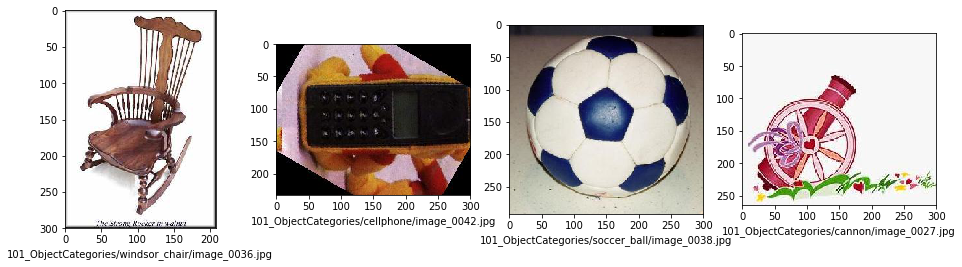

In [14]:
# Select 15 train/test images for each class
print('Select 15 train/test images for each class')
classes = next(os.walk(caltech_dir))[1]
train_image_ll = []
test_image_ll = []
for c in classes:
    class_dir = os.path.join(caltech_dir, c)
    ims = [f for f in next(os.walk(class_dir))[2] if f.endswith('.jpg')]
    random.shuffle(ims)
    train_image_ll.append([os.path.join(caltech_dir,c,f) for f in ims[:numTrain]])
    test_image_ll.append([os.path.join(caltech_dir,c,f) for f in ims[numTrain:numTrain+numTest]])
print('done')

# Show 4 random images
plt.figure(figsize=(16,4))
for i, idx in enumerate(random.sample(range(len(classes)), 4)):
    fpath = random.sample(train_image_ll[idx], 1)[0]
    plt.subplot(1, 4, i+1)
    plt.imshow(cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB))
    plt.xlabel(fpath)

# Dense SIFT(PHOW) and Visual Words

## 1. SIFT helper functions

In [22]:
sift = cv2.xfeatures2d.SIFT_create()

# Resize a image if it's too large
def standarizeImage(img):
    rows, cols = img.shape
    if cols > 480:
        img = cv2.resize(img, (480, rows*480//cols))
    return img

# Detect and extract SIFT from a single image
def SIFT(img):
    kp, des = sift.detectAndCompute(img, None)
    return des

# Load an image + Resize if large + Extract SIFT
def SIFT2(img_fpath):
    img = cv2.imread(img_fpath, cv2.IMREAD_GRAYSCALE)
    img = standarizeImage(img)
    kp, des = sift.detectAndCompute(img, None)
    return SIFT(img)

# Dense SIFT(Extract SIFT descriptor in grid points over an image)
def denseSIFT(img, step = 5, size = 7):
    rows, cols = img.shape[:2]
    kp = []
    for x in range(step,cols,step):
        for y in range(step,rows,step):
            kp.append(cv2.KeyPoint(x, y, size))
    kp, des = sift.compute(img, kp)
    return des

# Load an image + Resize if large + Dense SIFT
def denseSIFT2(img_fpath, step = 10):
    img = cv2.imread(img_fpath, cv2.IMREAD_GRAYSCALE)
    img = standarizeImage(img)
    return denseSIFT(img, step)

## 2. Visual Words(Train Vocabulary)

In [23]:
# Train vocabulary
if not os.path.exists(vocabPath):
    # Get PHOW features from 30 random training image to build a dictionary
    print("Extracting PHOW features some training images...")
    PHOW_descrs = []
    temp = [item for sublist in train_image_ll for item in sublist]
    temp = random.sample(temp, 30)
    for fpath in temp:
        des = denseSIFT2(fpath)
        PHOW_descrs.append(des)
    PHOW_descrs = np.concatenate(PHOW_descrs, axis=0)
    print("Total %d PHOW features" % PHOW_descrs.shape[0])
    
    # Quantize the descriptors to get the visual words
    print("Running K-means clustering (%d -> %d)..." % (PHOW_descrs.shape[0], numWords))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 500, 1.0)
    attempts = 10
    flags = cv2.KMEANS_RANDOM_CENTERS
    start_time = time.time()
    retval, bestLabels, vocab = cv2.kmeans(PHOW_descrs, numWords, None, criteria, attempts, flags)
    print('Elapsed time: %.6fs' % (time.time() - start_time))
    
    print('Saving...')
    with open(vocabPath, 'wb') as fd:
        pickle.dump(vocab, fd)
else:
    print("Load the trained visual words...")
    with open(vocabPath) as fd:
        vocab = pickle.load(fd)

print('Done!')

Extracting PHOW features some training images...
Total 18852 PHOW features
Running K-means clustering (18852 -> 600)...
Elapsed time: 546.472612s
Saving...
Done!


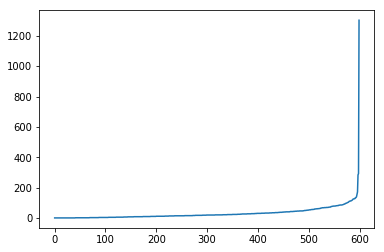

In [24]:
import collections
myCounter = collections.Counter(bestLabels.flatten())
plt.plot(sorted(myCounter.values()))

# Classification - SVM

## Spatial Histogram

In [40]:
bf = cv2.BFMatcher()

def getImageDescriptor(img, step=5, size=7):
    img = standarizeImage(img)
    cols, rows = img.shape[:2]
    
    # Extracting denseSIFT and BoW
    kp = []
    for x in range(step,cols,step):
        for y in range(step,rows,step):
            kp.append(cv2.KeyPoint(x, y, size))
    kp, des = sift.compute(img, kp)
    matches = bf.knnMatch(des, vocab, k=1)
    words = [m[0].trainIdx for m in matches]
    
    # Spatial Binning - 2x2
    binX = 2; binY = 2;
    temp = np.zeros((binX, binY, numWords), dtype=np.float32)
    for k, w in zip(kp, words):
        i = (int)(k.pt[0]) * binX // cols
        j = (int)(k.pt[1]) * binY // rows
        temp[i, j, w] += 1
    for i in range(binX):
        for j in range(binY):
            temp[i, j, :] //= np.sum(temp[i, j, :])
    temp = temp.flatten()
    hist = temp
    
    # Spatial Binning - 4x4
    binX = 4; binY = 4;
    temp = np.zeros((binX, binY, numWords), dtype=np.float32)
    for k, w in zip(kp, words):
        i = (int)(k.pt[0]) * binX // cols
        j = (int)(k.pt[1]) * binY // rows
        temp[i, j, w] += 1
    for i in range(binX):
        for j in range(binY):
            temp[i, j, :] //= np.sum(temp[i, j, :])
    temp = temp.flatten()
    hist = np.concatenate((hist, temp), axis=0)
    
    hist //= np.sum(hist)
    return hist    

## 1. Genarate spatial histogram for Training Images

In [41]:
# Extract spartial histogram for all training images
print('Extract spartial histogram for all training images')
BoW_train_ll = []
for c, image_list in zip(classes, train_image_ll):
    print(c, end=' ')
    temp = []
    for fpath in image_list:
        img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        temp.append(getImageDescriptor(img))
    BoW_train_ll.append(temp)

print('\ndone!')

Extract spartial histogram for all training images
gerenuk hawksbill headphone ant butterfly lamp strawberry water_lilly chandelier dragonfly crab pagoda dollar_bill emu inline_skate platypus dalmatian cup airplanes joshua_tree cougar_body grand_piano trilobite brontosaurus wild_cat pigeon dolphin soccer_ball wrench scorpion flamingo_head nautilus accordion cougar_face pyramid camera barrel schooner cellphone panda revolver lobster menorah lotus stapler crocodile chair helicopter minaret starfish ceiling_fan ketch mayfly wheelchair bass yin_yang crocodile_head saxophone beaver mandolin bonsai Leopards car_side ibis electric_guitar kangaroo stegosaurus ferry snoopy umbrella rhino okapi watch brain gramophone scissors rooster cannon binocular anchor octopus buddha laptop windsor_chair hedgehog pizza euphonium stop_sign Motorbikes sea_horse flamingo BACKGROUND_Google ewer garfield crayfish Faces_easy Faces sunflower llama elephant tick metronome 
done!


## 2. Train SVM

In [42]:
# Setting training data(BoW, label) for SVM
print('Setting training data(BoW, label) for SVM')
train_bow = []
train_labels = []
numSpartialHist = len(BoW_train_ll[0][0])
for i, BoW_list in enumerate(BoW_train_ll):
    for bow in BoW_list:
        # Hellinger's kernel for each training instance(bow)
        temp = np.sqrt(bow)
        temp -= np.average(temp)
        if np.std(temp) != 0:
            temp //= np.std(temp)
        train_bow.append([temp])
    train_labels.extend([i] * len(BoW_list))
train_bow = np.concatenate(train_bow, axis=0)
train_labels = np.array(train_labels, dtype=np.int).reshape((numTrain*numClasses,1))
# => train_bow: (1530, 12000), train_labels: (1530,1)

print("train_bow: " + str(train_bow.shape))
print("train_labels: " + str(train_labels.shape))

Setting training data(BoW, label) for SVM
train_bow: (1530, 12000)
train_labels: (1530, 1)


In [43]:
# Train SVM
print('Training SVM...')
svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setC(0.01)
svm.setTermCriteria((cv2.TERM_CRITERIA_COUNT, 10, 1.0))

start_time = time.time()
# svm.train(SVM_train_data)
svm.train(train_bow, cv2.ml.ROW_SAMPLE, train_labels)
print('Elapsed time: %.6fs' % (time.time() - start_time))

# print 'Saving SVM...'
# svm.save(svmPath)
print('Done!')

Training SVM...
Elapsed time: 3.680445s
Done!


In [44]:
train_preds = svm.predict(train_bow)[1]
print('Training Accuracy: %.6f' % np.average(train_preds == train_labels))

Training Accuracy: 0.009150


## 3. Test trained SVM

In [46]:
# Extract spartial histogram for all test images
print('Extract spartial histogram for all test images\n')
BoW_test_ll = []
for c, image_list in zip(classes, test_image_ll):
    print(c, end=' ')
    temp = []
    for fpath in image_list:
        img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        temp.append(getImageDescriptor(img))
    BoW_test_ll.append(temp)

print('\ndone!')

Extract spartial histogram for all test images

gerenuk hawksbill headphone ant butterfly lamp strawberry water_lilly chandelier dragonfly crab pagoda dollar_bill emu inline_skate platypus dalmatian cup airplanes joshua_tree cougar_body grand_piano trilobite brontosaurus wild_cat pigeon dolphin soccer_ball wrench scorpion flamingo_head nautilus accordion cougar_face pyramid camera barrel schooner cellphone panda revolver lobster menorah lotus stapler crocodile chair helicopter minaret starfish ceiling_fan ketch mayfly wheelchair bass yin_yang crocodile_head saxophone beaver mandolin bonsai Leopards car_side ibis electric_guitar kangaroo stegosaurus ferry snoopy umbrella rhino okapi watch brain gramophone scissors rooster cannon binocular anchor octopus buddha laptop windsor_chair hedgehog pizza euphonium stop_sign Motorbikes sea_horse flamingo BACKGROUND_Google ewer garfield crayfish Faces_easy Faces sunflower llama elephant tick metronome 
done!


In [47]:
# Setting test data(BoW, label) for SVM
print('Setting test data(BoW, label) for SVM')
test_bow = []
test_labels = []
numSpartialHist = len(BoW_test_ll[0][0])
for i, BoW_list in enumerate(BoW_test_ll):
    for bow in BoW_list:
        temp = np.sqrt(bow)
        temp -= np.average(temp)
        if np.std(temp) != 0:
            temp /= np.std(temp)
        test_bow.append([temp])
    test_labels.extend([i] * len(BoW_list))
test_bow = np.concatenate(test_bow, axis=0)
test_labels = np.array(test_labels, dtype=np.int).reshape((numTest*numClasses,1))
# => test_bow: (1530, 200), test_labels: (1530,1)

print(test_bow.shape)
print(test_labels.shape)

Setting test data(BoW, label) for SVM
(1530, 12000)
(1530, 1)


In [48]:
test_preds = svm.predict(test_bow)[1]
print('Test Accuracy: %.6f' % np.average(test_preds == test_labels))

Test Accuracy: 0.005882


## 4. Sample Results

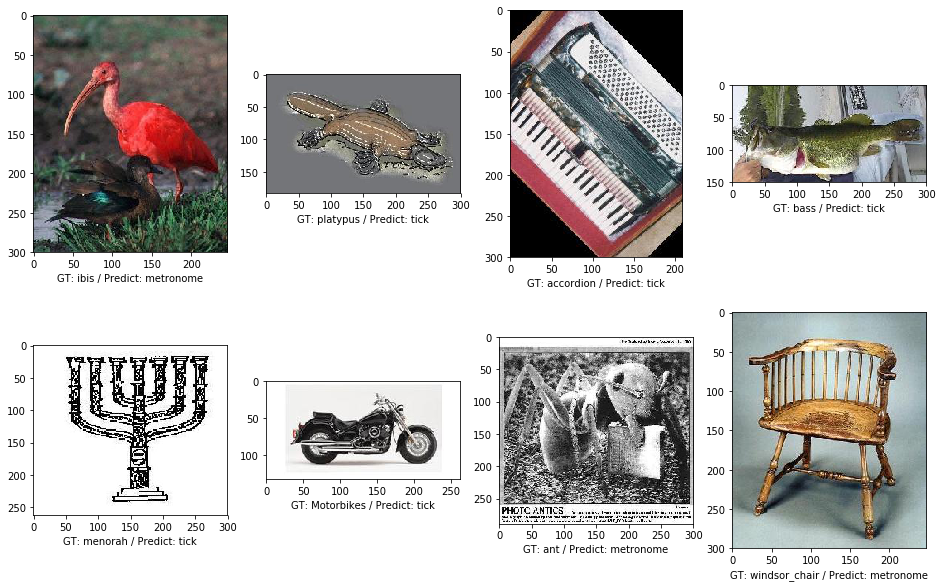

In [49]:
# Show 8 random images
plt.figure(figsize=(16,10))
for i, idx in enumerate(random.sample(range(len(classes)), 8)):
    # Extract Image Descriptor
    fpath = random.sample(test_image_ll[idx], 1)[0]
    img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
    bow = getImageDescriptor(img)
    
    # Hellinger's kernel
    temp = np.sqrt(bow)
    temp -= np.average(temp)
    if np.std(temp) != 0:
        temp //= np.std(temp)
    
    # Prediction
    test_preds = (int)(svm.predict(temp.reshape((1,12000)))[1][0,0])
    
    plt.subplot(2, 4, i+1)
    plt.imshow(cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB))
    plt.xlabel("GT: %s / Predict: %s" % (classes[idx], classes[test_preds]))

## Practice: Classification for your own image

Choose Classify your own test image using our classification.

- Place your image in the path where this notebook can access
- Load an image as grayscale
- Extract Dense SIFT BoW with `getImageDescriptor()`
- Normalize the bow with Hellinger's kernel
- Predict using the SVM classifier we have trained so far(`svm` instance)

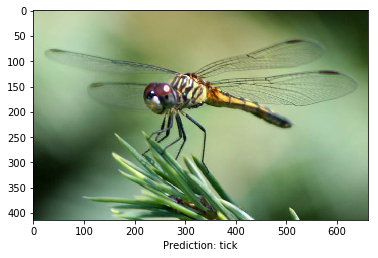

In [50]:
img_fpath = 'images/dragonfly.jpg'  # Path to your own image
img = cv2.imread(img_fpath, cv2.IMREAD_GRAYSCALE)

#================ YOUR CODE HERE ===================
bow = getImageDescriptor(img)
    
# Hellinger's kernel
temp = np.sqrt(bow)
temp -= np.average(temp)
if np.std(temp) != 0:
    temp //= np.std(temp)

# Prediction
prediction = (int)(svm.predict(temp.reshape((1,12000)))[1][0,0])  # Predicted class of your image
#===================================================

plt.imshow(cv2.cvtColor(cv2.imread(img_fpath), cv2.COLOR_BGR2RGB))
plt.xlabel("Prediction: %s" % classes[prediction])

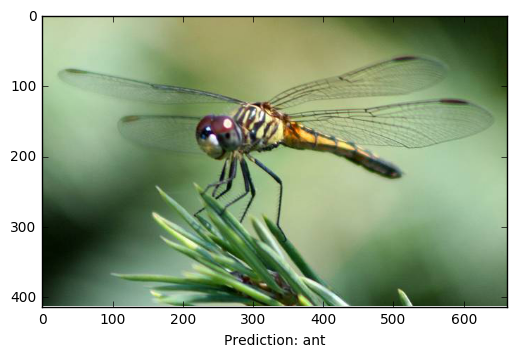

In [ ]:
# Desired output